# Assignment 0

In [224]:
import pandas as pd
import numpy as np
from numpy import linalg as LNG
from sklearn.decomposition import PCA
import umap
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm, ListedColormap
from sklearn.metrics import confusion_matrix

np.random.seed(42)

# Supress deprecation warnings
import warnings
warnings.filterwarnings('error', category=DeprecationWarning) 

In [193]:
# Training inputs (image as vector)
X_train = pd.read_csv("data/train_in.csv").to_numpy()

# Training outputs (number that each vector represents)
Y_train = pd.read_csv("data/train_out.csv").to_numpy()

X_test = pd.read_csv("data/test_in.csv").to_numpy()
Y_test = pd.read_csv("data/test_out.csv").to_numpy()

## Calculating the center for each cloud c_d

In [194]:
def get_digit_cloud(X, Y, digit):
    # Finding all the indexes from Y_train_out related to digit
    d_indices = np.where(Y == digit)[0]

    # an array of all images related to the current d
    return X[d_indices]

In [195]:
# Stores calculated centers
# Label corresponds to index, eg. Center_0 = clouds[0]
cloud_centers = []

for d in range(10):
    cloud_d = get_digit_cloud(X_train, Y_train, d)

    # Calculating the mean/center of each cloud
    center_d = np.mean(cloud_d, axis=0)

    # add each mean vector to clouds
    cloud_centers.append(center_d)

## Calculating center distances for each digit/label

In [196]:
distances_matrix = np.full((10,10), np.NaN)

for row_index in range(0,10):
    for column_index in range(0,10):
        if column_index == row_index or not np.isnan(distances_matrix[column_index, row_index]):
            continue

        c1 = cloud_centers[row_index]
        c2 = cloud_centers[column_index]
        
        distances_matrix[row_index, column_index] = LNG.norm(c1 - c2)

In [197]:
pd.DataFrame(distances_matrix)

,0,1,2,3,4,5,6,7,8,9
0,NaN,14.449608,9.334556,9.143734,10.769844,7.519296,8.163019,11.864555,9.907902,11.488875
1,NaN,NaN,10.125323,11.733233,10.173786,11.118800,10.597933,10.743154,10.086777,9.932094
2,NaN,NaN,NaN,8.178285,7.932541,7.906796,7.317952,8.872531,7.077516,8.887748
3,NaN,NaN,NaN,NaN,9.087608,6.118750,9.292426,8.922401,7.020425,8.354350
4,NaN,NaN,NaN,NaN,NaN,8.001517,8.765997,7.583012,7.380909,6.010408
5,NaN,NaN,NaN,NaN,NaN,NaN,6.688629,9.211954,6.967386,8.258538
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.868157,8.570208,10.419744
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.467785,5.426474
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.401166
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dimensionality Reduction

In [198]:
def visualize(X, Y, title):
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='Set1', s=5)
    plt.colorbar()
    plt.title(title)
    plt.show()

### PCA

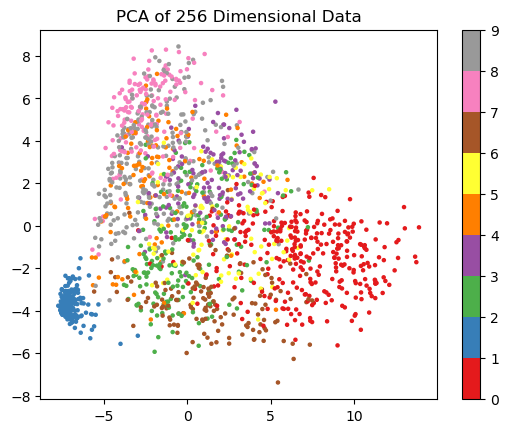

In [199]:
# Initiaze PCA
pca = PCA(n_components=2, random_state=42)

# Fit PCA to data
clouds_PCA = pca.fit_transform(X_train)

#show data
visualize(clouds_PCA, Y_train, "PCA of 256 Dimensional Data")
    

### U-MAP

In [200]:
# initialize UMAP
umap_reducer = umap.UMAP(random_state=42)

# Fit UMAP model to data
clouds_umap = umap_reducer.fit_transform(X_train)

# show data
visualize(clouds_umap, Y_train, "UMAP Projection of 256 Dimensional Data")

AttributeError: module 'umap' has no attribute 'UMAP'

### T-SNE

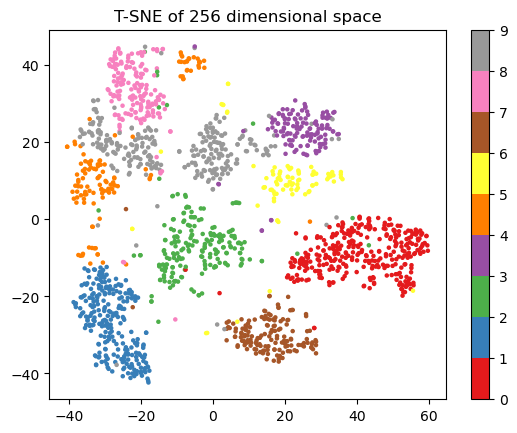

In [211]:
#Initialize T-SNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42)

# Fit TSNE model to data
cloud_tsne = tsne.fit_transform(X_train)

#show data
visualize(cloud_tsne, Y_train, "T-SNE of 256 dimensional space")


### Define Nearest Mean Classifier

In [202]:
def nearest_mean_classifier(new_vectors):
    Y_predict = []

    for v in new_vectors:
        distances_to_clouds = [LNG.norm(v-center) for center in cloud_centers]

        # Returns the label for the first closest cloud
        Y_predict.append(np.argmin(distances_to_clouds))
    return Y_predict

### Train K-Nearest-Neighbor Classifier

In [203]:
knn = KNeighborsClassifier()
knn.fit(X_train, np.ravel(Y_train))

KNeighborsClassifier()

## Testing NearestMeanClassifier & KNearestNeighborClassifier accuracy

In [214]:
def get_accuracy(X, Y, classifier):
    correct = 0

    Y_predict = classifier(X)

    for y_predict, y in zip(Y_predict, Y):
        if y_predict == y:
            correct+=1

    return round(correct / X.shape[0] * 100, 2)

### Accurracy on training set

In [215]:
nm_acc = get_accuracy(X_train, Y_train, nearest_mean_classifier)
print(f'Nearest Mean accuracy on training set: {nm_acc}%')

knn_acc = get_accuracy(X_train, Y_train, knn.predict)
print(f'KNN accuracy on training set: {knn_acc}%')

Nearest Mean accuracy on training set: 86.34%
KNN accuracy on training set: 96.6%


### Accurracy on test set

In [216]:
nm_acc = get_accuracy(X_test, Y_test, nearest_mean_classifier)
print(f'Nearest Mean accuracy on test set: {nm_acc}%')

knn_acc = get_accuracy(X_test, Y_test, knn.predict)
print(f'KNN accuracy on test set: {knn_acc}%')

Nearest Mean accuracy on test set: 80.38%
KNN accuracy on test set: 90.79%


### Confusion Matrix

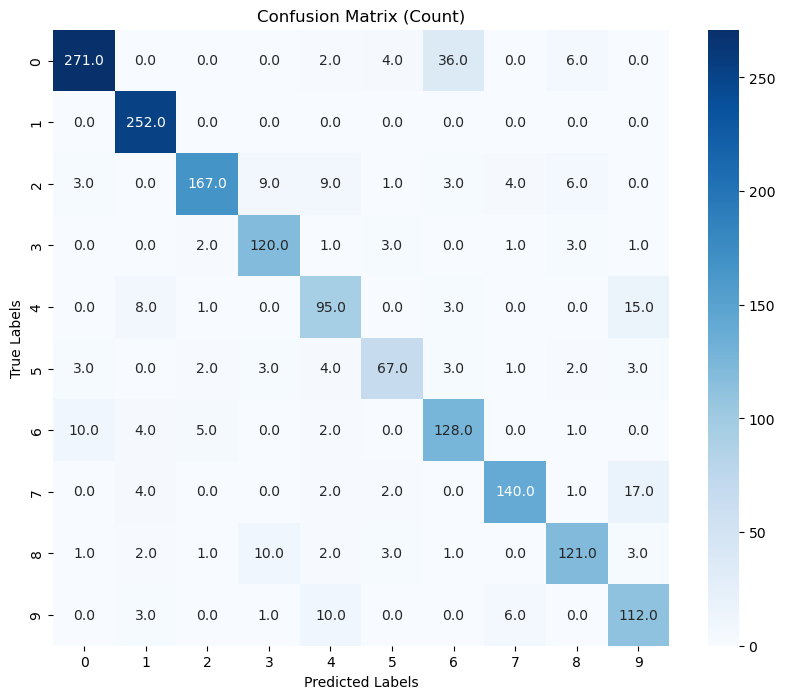

In [230]:
Y_predict = nearest_mean_classifier(X_train)
cm_nmc = confusion_matrix(Y_train, Y_predict)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nmc, annot=True, fmt=".1f", cmap="Blues", square=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Count)")
plt.show()